# Chapter 3 of HOML 2nd edition

In [9]:
import numpy as np
import pandas as pd

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version = 1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [10]:
X, y = mnist["data"], mnist["target"]
y = y.astype(np.uint8) #make it an integer, not a string
X_train, X_test, y_train, y_test = X[:60000], X[60000: ], y[:60000], y[60000:]

In [11]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [12]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring = "accuracy")

array([0.95035, 0.96035, 0.9604 ])

However, accuracy is not a great measure. Always guessing that a digit is not a 5 would be 90% accurate since only 10% of the data are 5s. To set up for a confusion matrix requires two steps

In [15]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [16]:
sk_matrix = confusion_matrix(y_train_5, y_train_pred)

687

In [25]:
pd.DataFrame(sk_matrix, columns = ["Negative", "Positive"], index = ["Negative", "Positive"])

,Negative,Positive
Negative,53892,687
Positive,1891,3530


There are a lot of names for the metrics you can make from the confusion matrix. The two most important are
- precision (true positives over those you think are positive)
- recall (true positives over all actual positives)

In [27]:
def format_confusion_matrix(sk_matrix):
    labeled_df = pd.DataFrame(sk_matrix, columns = ["Negative", "Positive"], index = ["Negative", "Positive"])
    
    return labeled_df

def confusion_metrics(sk_matrix):
    tn = sk_matrix[0, 0]
    fp = sk_matrix[0, 1]
    fn = sk_matrix[1, 0]
    tp = sk_matrix[1, 1]

    precision = tp/(tp + fp) #out of those you think are positive, how often are you correct?
    recall = tp/(tp + fn) #out of all positives in the population, how many are you catching? 
    # For recall, consider a quality assurance case where you need to recall faulty products. How many of those that should be recalled
    # is your model actually catching
    f_score = 2/ ((1/precision) + (1/recall)) #harmonic mean, weighs low scores more highly than an arithmetic mean
    # In general you should not use an f_score uncritically. The actual situation determines if we care more about
    # recall or precision, but it's generally bad to just put them together in one metric

    metric_df = pd.DataFrame({'metric': [precision, recall, f_score]}, index = ["Precision", "Recall", "F Score"])

    return metric_df


In [29]:
confusion_metrics(sk_matrix)

,metric
Precision,0.837088
Recall,0.651171
F Score,0.732517


You can also plot a curve of precision and recall. You can change the threshold at which something is classified as 'true'. 
- At a higher threshold, fewer things will be classified as true
- So high thresholds have high precision and low recall

We can use sklearn to look at precision and recall values at different thresholds

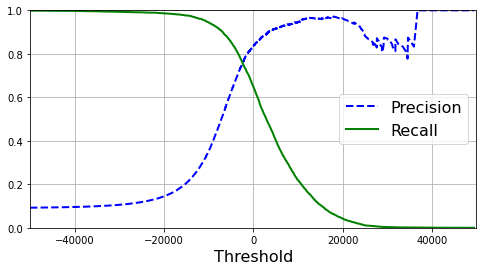

In [33]:
# set up for matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# model used to make classification decisions
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    plt.axis([-50000, 50000, 0, 1])             

plt.figure(figsize=(8, 4))                                                                  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

Another common way to consider the trade-offs is the reciever operating characteristic (ROC) curve. It is a plot of 
- true postive rate (recall) (sensitivity) (tp / tp + fn)
- false positive rate (fall-out) (fp/ tn + fp)

The True Negative Rate (TNR) is also known as _specificity_ and the False Positive Rate is equal to 1 - specificity.

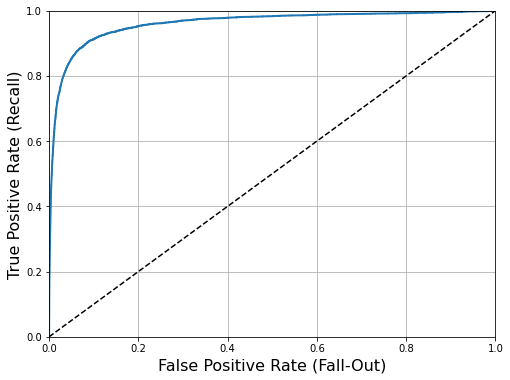

In [36]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
#fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
#plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
#plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
#plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
#save_fig("roc_curve_plot")                                    # Not shown
plt.show()


One useful measure here can be the area under the curve, which gives an indication of how well the classifier performs across various thresholds. A perfect classifier has a 1, a random classifier has a 0.5

In [37]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Part of the usefulness of these metrics is to compare different classifiers, so let's train another and plot them both. 

In [39]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probs_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, method = "predict_proba")

In [43]:
y_scores_forest = y_probs_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

In [45]:
# you can find out what a function returns this way, and the list should be in order
?roc_curve

Signature:
roc_curve(
    y_true,
    y_score,
    *,
    pos_label=None,
    sample_weight=None,
    drop_intermediate=True,
)
Docstring:
Compute Receiver operating characteristic (ROC).

Note: this implementation is restricted to the binary classification task.

Read more in the :ref:`User Guide <roc_metrics>`.

Parameters
----------
y_true : ndarray of shape (n_samples,)
    True binary labels. If labels are not either {-1, 1} or {0, 1}, then
    pos_label should be explicitly given.

y_score : ndarray of shape (n_samples,)
    Target scores, can either be probability estimates of the positive
    class, confidence values, or non-thresholded measure of decisions
    (as returned by "decision_function" on some classifiers).

pos_label : int or str, default=None
    The label of the positive class.
    When ``pos_label=None``, if `y_true` is in {-1, 1} or {0, 1},
    ``pos_label`` is set to 1, otherwise an error will be raised.

sample_weight : array-like of shape (n_samples,), defaul

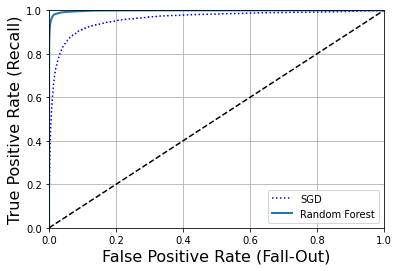

In [46]:
plt.plot(fpr, tpr, "b:", label = "SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc = "lower right")
plt.show()

No matter where we choose to be along the ROC curve, the Random Forest classifier is better than the SGD one. For any Recall we choose we will still get a lower corresponding False Positive Rate

In [47]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

# Multiclass Classification